In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np

In [2]:
# Load data and labels
labels = pd.read_csv("./data/train_labels.csv")
image_folder = "./data/Train/"
label_encoder = LabelEncoder()
labels["label"] = label_encoder.fit_transform(labels["label"])

In [3]:
def crop_pokemon(img_path):
    img = Image.open(img_path)
    gray_img = img.convert("L") # Convert to grayscale
    img_array = np.array(gray_img)

    # Detect black silhouette (thresholding)
    threshold = 10  # Adjust this value if needed
    mask = img_array < threshold

    # Get coordinates of silhouette (bounding box)
    coords = np.column_stack(np.where(mask))
    if coords.shape[0] == 0:
        return img.resize((64, 64))  # If no silhouette found, return resized image

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Apply padding (5%)
    pad = int(0.05 * min(x_max - x_min, y_max - y_min))
    x_min, y_min = max(0, x_min - pad), max(0, y_min - pad)
    x_max, y_max = min(img.width, x_max + pad), min(img.height, y_max + pad)

    cropped_img = img.crop((x_min, y_min, x_max, y_max))
    cropped_img = cropped_img.resize((64, 64))

    return cropped_img

In [9]:
class PokemonDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.df.iloc[idx, 0]) + ".png")

        #image = crop_pokemon(img_name)
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        if len(self.df.columns) > 1:  # Train Set has labels, Test does not.
            label = self.df.iloc[idx, 1]
            name = str(self.df.iloc[idx, 0]) + ".png"
            return image, label, name
        else:  
            return image, -1, name  # X dont care for Test

In [10]:
dataset = PokemonDataset(labels, image_folder)

In [13]:
gray_img = dataset[1][0].convert("L")

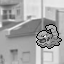

In [14]:
gray_img

In [11]:
dataset = PokemonDataset(labels, image_folder)
for i in range(len(dataset)):
    dataset[i][0].save(os.path.join("data/TrainCropped", dataset[i][2]))